In [1]:
import os
import time
from glob import glob
from tqdm import tqdm
import cv2
import sklearn.utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Loading in dataset
Instead of using an `ImageDataGenerator` from TensorFlow, we can make the dataset our self and preprocess it. We can add image augmentation with OpenCV, but for this one, it would be a bit too overkill. We first make a function that makes loading in the dataset easier and modular. Then, we actually use the function to create the training dataset.

In [2]:
def make_dataset(dataset_name, directory, classes, width, height, ending=".jpg"):
    start = time.time()
    X = []
    y = []
    for cls in tqdm(classes):
        path = os.path.join(directory, dataset_name, dataset_name, cls, "*" + ending)
        images = glob(path)
        for image in images[:len(images)//2]: # only getting half
            img = cv2.imread(image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
            img = img / 255.
            X.append(img)
            y.append(cls)
            # image augmentation goes here (if needed)
    X = np.array(X).reshape(-1, width, height, 3)
    y = np.array(y)
    X, y = sklearn.utils.shuffle(X, y, random_state=42)
    end = time.time()
    print(f"Loading in {dataset_name} dataset finished in {round(end-start, 2)} second(s).")
    return X, y

In [3]:
WIDTH = 64
HEIGHT = 64

directory = "../input/asl-alphabet/"
alphabet = "A B C D E F G H I J K L M N O P Q R S T U V W X Y Z nothing"
classes = alphabet.split(' ')

X_train, y_train = make_dataset("asl_alphabet_train", directory, classes, WIDTH, HEIGHT)

100%|██████████| 27/27 [04:47<00:00, 10.66s/it]


Loading in asl_alphabet_train dataset finished in 295.65 second(s).


In [4]:
X_train.shape,y_train.shape

((40500, 64, 64, 3), (40500,))

### Visualizing
We can now visualize our dataset by looking at 5 of our images in the dataset with its respective labels.

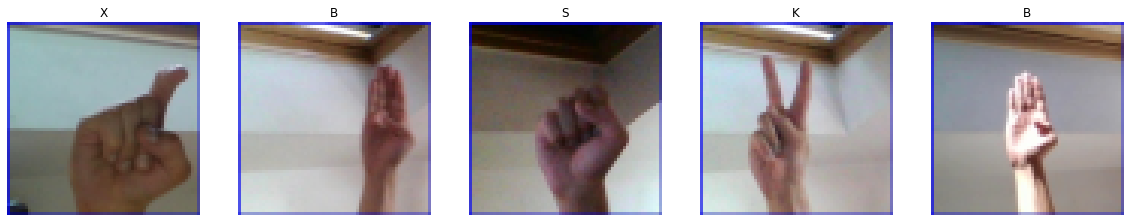

In [5]:
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    rand = np.random.randint(0, X_train.shape[0]-1)
    plt.title(y_train[rand])
    plt.axis(False)
    plt.imshow(X_train[rand], cmap=plt.cm.gray)

### Preprocessing
Now that we have preprocessed our images, we also need to preprocesses our labels into numbers, and then to one hot encodings/binary class matrix.

In [6]:
import sklearn.preprocessing

le = sklearn.preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train)

### Making the model
Now, like every other computer vision model I do, we are building a convolutional neural network. We will be creating it using the Sequential model, but with a different syntax this time. We will be using a dropout layer and l2 regualizers. We will also add in batch normalization. This is all to make sure our model is stable, doesn't overfit, and it can train faster. Our learning rate for the Adam optimizer is default of `0.001`. We will also make a validation set to moderate our model and see how well it can predict on pictures it hasn't see before.

In [8]:
tf.random.set_seed(42)
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (64,64,3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (3,3)))

model.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (3,3)))
          
model.add(tf.keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (3,3)))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(len(classes), activation = 'softmax'))

model.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ["accuracy"])

history = model.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_split = 0.1)

Epoch 1/5
570/570 [==============================] - 261s 455ms/step - loss: 2.1394 - accuracy: 0.4797 - val_loss: 0.5824 - val_accuracy: 0.9015
Epoch 2/5
570/570 [==============================] - 252s 443ms/step - loss: 0.4227 - accuracy: 0.9397 - val_loss: 0.2606 - val_accuracy: 0.9679
Epoch 3/5
570/570 [==============================] - 254s 446ms/step - loss: 0.2462 - accuracy: 0.9703 - val_loss: 0.2060 - val_accuracy: 0.9691
Epoch 4/5
570/570 [==============================] - 252s 442ms/step - loss: 0.1777 - accuracy: 0.9796 - val_loss: 0.3374 - val_accuracy: 0.9195
Epoch 5/5
570/570 [==============================] - 252s 442ms/step - loss: 0.1771 - accuracy: 0.9769 - val_loss: 0.1896 - val_accuracy: 0.9775


### Visualizing our model
First, we can see that our model converges which is a good sign. We can also use our model to predict on the test dataset so that is what we will be doing next.

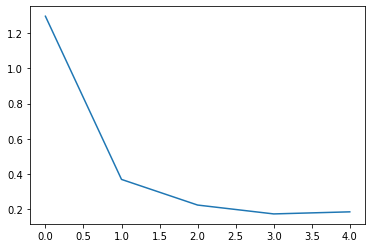

In [25]:
plt.plot(history.history["loss"])

### Predicting
We will use our model to predict. So we will make a helper function for loading in the image, and then, we will create the train and test dataset. Since the train and test dataset came in different forms, we cannot use our helper function. So, we will have to load in the image and take out the label from the file name.

In [27]:
WIDTH = 64
HEIGHT = 64

def load_image(path, classes=classes):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
    img = img / 255.
    return img

In [10]:
# Since we only want to train on the alphabet, we will omit the "space" and "del" test case since we didn't train on it (as it is not in the alphabet)

test_dirs = glob("../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/*.jpg")
key = "../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/" 
X_test = []
y_test = []
for dir in test_dirs:
    true = dir[dir.find(key)+len(key):dir.find("_test.jpg")]
    if true != "space" and true != "del":
        y_test.append(true)
        X_test.append(load_image(dir, classes=classes))
    
X_test = np.array(X_test).reshape(-1, WIDTH, HEIGHT, 3)
y_test = np.array(y_test)
X_test.shape, y_test.shape

((27, 64, 64, 3), (27,))

Prediction: P
Actual: P


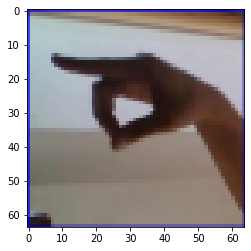

In [22]:
index = np.random.randint(0, X_test.shape[0]-1)
pred = model.predict(X_test[index].reshape(-1, WIDTH, HEIGHT, 3))
prediction = classes[np.argmax(pred)]
actual = y_test[index]
print(f"Prediction: {prediction}")
print(f"Actual: {actual}")
plt.imshow(X_test[index])

In [38]:
preds = model.predict(X_test)
for pred, true in zip(le.inverse_transform(np.argmax(preds, axis=1)), y_test):
    print(f"Prediction: {pred}, Actual: {true}")

Prediction: A, Actual: A
Prediction: E, Actual: E
Prediction: L, Actual: L
Prediction: N, Actual: N
Prediction: S, Actual: S
Prediction: D, Actual: D
Prediction: G, Actual: G
Prediction: I, Actual: I
Prediction: W, Actual: W
Prediction: N, Actual: M
Prediction: nothing, Actual: nothing
Prediction: X, Actual: X
Prediction: H, Actual: H
Prediction: Q, Actual: Q
Prediction: C, Actual: C
Prediction: T, Actual: T
Prediction: P, Actual: P
Prediction: V, Actual: V
Prediction: Y, Actual: Y
Prediction: U, Actual: U
Prediction: O, Actual: O
Prediction: B, Actual: B
Prediction: R, Actual: R
Prediction: F, Actual: F
Prediction: Z, Actual: Z
Prediction: J, Actual: J
Prediction: K, Actual: K


### Final remarks
Our model did really well, and it is able to predict most, if not all of the pictures right!